In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [49]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        if x.size(-1) == 8:
            batch_size = x.size(0)
            # Option 1: Take first 4 features
            # x = x[:, :4]
            
            # Option 2: Or reshape if the 8 features should be interpreted differently
            # x = x.view(batch_size, 4)
            
            # Option 3: Or use a projection if all 8 features are important
            self.projection = nn.Linear(8, 4)
            x = self.projection(x)
        
        # Ensure we have the right number of dimensions
        if x.size(-1) != 4:
            raise ValueError(f"Expected input with 4 features, got {x.size(-1)}")
            
        return self.fc(x)

In [50]:
def compute_discounted_rewards(rewards, gamma=0.99):
    discounted = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        discounted.insert(0, R)
    return torch.tensor(discounted)

In [64]:
def train(env, policy, optimizer, episodes=50000):
    episode_rewards = []
    best_reward = float("-inf")
    best_episode = {
        "reward": 0,
        "trajectory": []
    }

    for episode in range(episodes):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        trajectory = []
        done = False
        
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = policy(state_tensor)
            m = Categorical(probs)
            action = m.sample()

            log_probs.append(m.log_prob(action))

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            rewards.append(reward)
            trajectory.append((state, action.item(), reward))
            state = next_state

        total_reward = sum(rewards)
        episode_rewards.append(total_reward)
        
        if total_reward > best_reward:
            best_reward = total_reward
            best_episode["reward"] = total_reward
            best_episode["trajectory"] = trajectory

        discounted_rewards = compute_discounted_rewards(rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        
        policy_loss = []
        for log_prob, Gt in zip(log_probs, discounted_rewards):
            policy_loss.append(-log_prob * Gt)
        
        optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        optimizer.step()
        
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")
        
    return episode_rewards, best_episode

In [65]:
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5
)

policy = PolicyNetwork()
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

In [66]:
rewards, best_episode = train(env, policy, optimizer)

print("\n")
print("="*100)

print(f"\nBest Episode Reward: {best_episode["reward"]}")
print("Sample of Best Episode Trajectory:")
for step in best_episode["trajectory"][:5]:
    state, action, reward = step
    print(f"State: {state}, Action: {action}, Reward: {reward}")

Episode 0, Total Reward: -393.06714319813227
Episode 100, Total Reward: -356.9413416120668
Episode 200, Total Reward: -268.4868290491478
Episode 300, Total Reward: -277.0167152164844
Episode 400, Total Reward: -374.32475542105277
Episode 500, Total Reward: -314.1939855408516
Episode 600, Total Reward: -318.59234093574327
Episode 700, Total Reward: -355.409162940156
Episode 800, Total Reward: -235.76046981751367
Episode 900, Total Reward: -310.3926973860214
Episode 1000, Total Reward: -241.19920886900243
Episode 1100, Total Reward: -175.22128050176065
Episode 1200, Total Reward: -166.09462420280903
Episode 1300, Total Reward: -217.63563964493417
Episode 1400, Total Reward: -295.04536164027917
Episode 1500, Total Reward: -165.63760237449938
Episode 1600, Total Reward: -220.34390963555643
Episode 1700, Total Reward: -194.92242505918392
Episode 1800, Total Reward: -286.3497132037081
Episode 1900, Total Reward: -113.36640918667351
Episode 2000, Total Reward: -150.82309587931962
Episode 2100

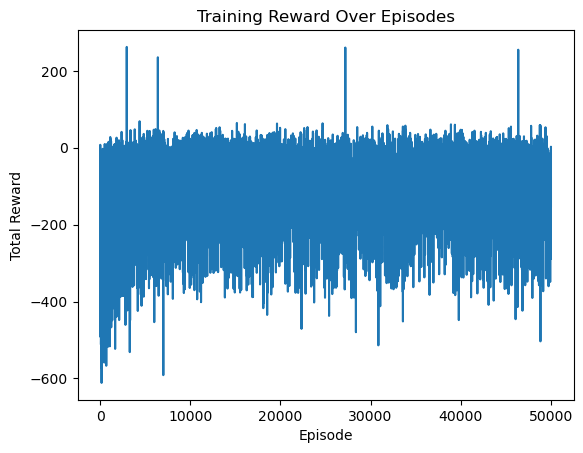

In [67]:
plt.plot(rewards)
plt.title("Training Reward Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()